In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sbihack/HACKATHON_PREDICTION_DATA.CSV
/kaggle/input/sbihack/HACKATHON_TRAINING_DATA.CSV
/kaggle/input/post-processing-done/processed.csv


In [4]:
df = pd.read_csv('/kaggle/input/sbihack/HACKATHON_TRAINING_DATA.CSV')

In [2]:
df = pd.read_csv('/kaggle/input/sbihack/HACKATHON_PREDICTION_DATA.CSV')

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# Enable tqdm for pandas apply
tqdm.pandas()

# Set thresholds
low_thresh = 0.005
mid_thresh = 0.10

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# 1. DROP rows where missing values are in columns with < 0.5% missing
print("Step 1: Dropping rows with missing values in columns with <0.5% missing...")
missing_percent = df.isnull().mean()
cols_to_drop_rows = missing_percent[missing_percent < low_thresh].index

if not cols_to_drop_rows.empty:
    print(f"Dropping rows for columns: {list(cols_to_drop_rows)}")
    df = df.dropna(subset=cols_to_drop_rows)

# 2. Mean ± Std Imputation for Numerical Columns with 0.5% to 10% missing
print("\nStep 2: Mean ± Std Imputation for numerical columns with 0.5–10% missing...")
impute_cols = missing_percent[(missing_percent >= low_thresh) & (missing_percent <= mid_thresh)]
impute_numerical = [col for col in impute_cols.index if col in numerical_cols]

for col in tqdm(impute_numerical, desc="Imputing numerical columns"):
    mean = df[col].mean()
    std = df[col].std()
    mask = df[col].isnull()
    imputed_values = np.random.normal(loc=mean, scale=std, size=mask.sum())
    df.loc[mask, col] = imputed_values

# 3. Random Sampling Imputation for Categorical Columns with 0.5% to 10% missing
print("\nStep 3: Random sampling for categorical columns with 0.5–10% missing...")
impute_categorical = [col for col in impute_cols.index if col in categorical_cols]

for col in tqdm(impute_categorical, desc="Imputing categorical columns"):
    non_null_values = df[col].dropna().values
    mask = df[col].isnull()
    imputed_values = np.random.choice(non_null_values, size=mask.sum(), replace=True)
    df.loc[mask, col] = imputed_values

print("\n✅ Imputation using mean ± std (numerical) and random sampling (categorical) complete.")


Step 1: Dropping rows with missing values in columns with <0.5% missing...
Dropping rows for columns: ['ACCT_AGE', 'LIMIT', 'OUTS', 'ACCT_RESIDUAL_TENURE', 'LOAN_TENURE', 'INSTALAMT', 'SI_FLG', 'AGE', 'VINTAGE', 'KYC_SCR', 'LOCKER_HLDR_IND', 'UID_FLG', 'KYC_FLG', 'INB_FLG', 'EKYC_FLG', 'NO_LONS', 'ALL_LON_LIMIT', 'ALL_LON_OUTS', 'ALL_LON_MAX_IRAC', 'OLDEST_LON_TAKEN', 'LATEST_LON_TAKEN', 'LATEST_RESIDUAL_TENURE', 'OLDEST_RESIDUAL_TENURE', 'POP_CODE', 'TOT_IRAC_CHNG', 'TIMES_IRAC_SLIP', 'TIMES_IRAC_UPR', 'LAST_1_YR_RG3', 'LAST_1_YR_RG2', 'AGREG_GROUP', 'PRODUCT_TYPE', 'LATEST_CR_DAYS', 'LATEST_DR_DAYS', 'TIME_PERIOD', 'UNIQUE_ID']

Step 2: Mean ± Std Imputation for numerical columns with 0.5–10% missing...


Imputing numerical columns: 100%|██████████| 90/90 [00:00<00:00, 249.07it/s]



Step 3: Random sampling for categorical columns with 0.5–10% missing...


Imputing categorical columns: 100%|██████████| 3/3 [00:00<00:00, 55.89it/s]


✅ Imputation using mean ± std (numerical) and random sampling (categorical) complete.


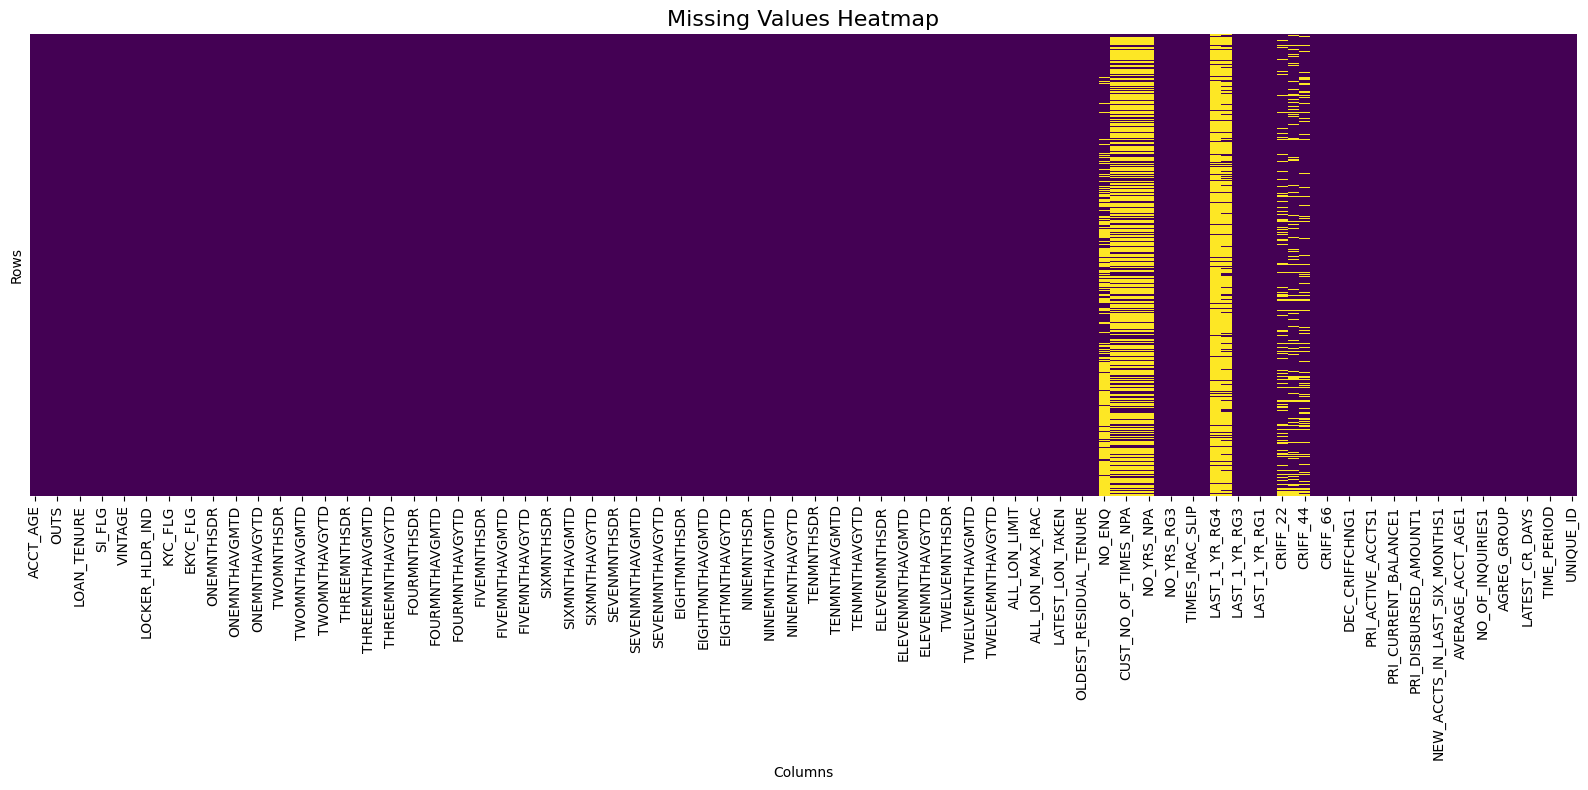

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the heatmap
sns.heatmap(df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim

# ==== Autoencoder Definition ====
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(X_np, num_epochs=100, lr=0.01):
    X_tensor = torch.FloatTensor(X_np)
    model = Autoencoder(X_np.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()

    return model


# ==== CATEGORY 3 Imputation ====
def impute_category3(train):
    train = train.copy()

    # 1️⃣ Impute CRIFF_22 from CRIFF_11 using Autoencoder
    if 'CRIFF_11' in train.columns and 'CRIFF_22' in train.columns:
        ae_train = train[['CRIFF_11', 'CRIFF_22']].dropna()
        if not ae_train.empty:
            scaler_11 = StandardScaler()
            X_11 = scaler_11.fit_transform(ae_train[['CRIFF_11']])

            autoencoder = train_autoencoder(X_11, num_epochs=200)

            mask = train['CRIFF_22'].isnull() & train['CRIFF_11'].notnull()
            if mask.sum() > 0:
                X_missing = scaler_11.transform(train.loc[mask, ['CRIFF_11']])
                autoencoder.eval()
                with torch.no_grad():
                    X_tensor = torch.FloatTensor(X_missing)
                    pred_22 = autoencoder(X_tensor).numpy()

                train.loc[mask, 'CRIFF_22'] = pred_22.flatten()
                print(f"Imputed CRIFF_22 for {mask.sum()} rows using Autoencoder.")

    # 2️⃣ Impute CRIFF_33 from CRIFF_11 + CRIFF_22 using MLP
    if all(col in train.columns for col in ['CRIFF_11', 'CRIFF_22', 'CRIFF_33']):
        mlp_train = train[['CRIFF_11', 'CRIFF_22', 'CRIFF_33']].dropna()
        if not mlp_train.empty:
            X = mlp_train[['CRIFF_11', 'CRIFF_22']]
            y = mlp_train['CRIFF_33']

            mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=300, random_state=42)
            mlp.fit(X, y)

            mask = train['CRIFF_33'].isnull() & train['CRIFF_11'].notnull() & train['CRIFF_22'].notnull()
            X_missing = train.loc[mask, ['CRIFF_11', 'CRIFF_22']]
            if not X_missing.empty:
                preds = mlp.predict(X_missing)
                train.loc[mask, 'CRIFF_33'] = preds
                print(f"Imputed CRIFF_33 for {len(X_missing)} rows using MLP.")

    # 3️⃣ Impute CRIFF_44 from CRIFF_55 + CRIFF_66 using MLP
    if all(col in train.columns for col in ['CRIFF_55', 'CRIFF_66', 'CRIFF_44']):
        mlp_train = train[['CRIFF_55', 'CRIFF_66', 'CRIFF_44']].dropna()
        if not mlp_train.empty:
            X = mlp_train[['CRIFF_55', 'CRIFF_66']]
            y = mlp_train['CRIFF_44']

            mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=300, random_state=42)
            mlp.fit(X, y)

            mask = train['CRIFF_44'].isnull() & train['CRIFF_55'].notnull() & train['CRIFF_66'].notnull()
            X_missing = train.loc[mask, ['CRIFF_55', 'CRIFF_66']]
            if not X_missing.empty:
                preds = mlp.predict(X_missing)
                train.loc[mask, 'CRIFF_44'] = preds
                print(f"Imputed CRIFF_44 for {len(X_missing)} rows using MLP.")

    return train


In [7]:
df = impute_category3(df)

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Imputed CRIFF_22 for 101167 rows using Autoencoder.


In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#%% CONFIGURATION
# Define the columns that contain missing values
columns_to_impute = [
    'LAST_1_YR_RG4', 'LAST_3_YR_RG4', 'FIRST_NPA_TENURE',
    'NO_YRS_NPA', 'CUST_NO_OF_TIMES_NPA', 'LATEST_NPA_TENURE', 'NO_ENQ'
]
# The user explicitly requested not to use the target column, so classifier is disabled.
use_classifier = False 

# Hyperparameters
alpha = 10            # Weight for reconstruction loss in Generator
mb_size = 32          # Mini-batch size
p_hint = 0.9          # Probability of revealing the true mask M in the hint matrix K
epochs = 3000         # Number of training epochs

# Assuming 'df' DataFrame is already loaded and available in the environment.
# Example df structure (replace with your actual data loading):
# df = pd.DataFrame({
#     'LAST_1_YR_RG4': [10, 20, np.nan, 40, 50, 60, np.nan, 80],
#     'LAST_3_YR_RG4': [100, np.nan, 300, 400, 500, np.nan, 700, 800],
#     'FIRST_NPA_TENURE': [1, 2, 3, np.nan, 5, 6, 7, 8],
#     'NO_YRS_NPA': [0, 1, 0, 1, 0, 1, 0, 1],
#     'CUST_NO_OF_TIMES_NPA': [1, 2, 1, 3, 2, 1, 3, 2],
#     'LATEST_NPA_TENURE': [10, 20, 30, 40, np.nan, 60, 70, 80],
#     'NO_ENQ': [5, 10, 15, 20, 25, 30, 35, np.nan],
#     'TARGET': ['A', 'B', 'A', 'B', 'A', np.nan, 'B', 'A'] # This column will not be used by the model.
# })


#%% PREPROCESSING - ROBUST VERSION
print("🔧 Preprocessing data...")

# Extract data
data = df[columns_to_impute].copy()

print(f"📊 Data shape: {data.shape}")
print(f"📊 Missing values per column:")
for col in columns_to_impute:
    missing = data[col].isna().sum()
    total = len(data[col])
    print(f"   {col}: {missing}/{total} ({missing/total*100:.1f}%)")

# Create original mask of observed values for all data
M_original = (~data.isna()).astype(float).values

# Fill NaN with column means instead of zeros (more robust for scaling)
data_filled = data.copy()
for col in columns_to_impute:
    if data_filled[col].isna().all():
        # If all values are NaN, fill with 0
        data_filled[col] = 0
    else:
        # Fill with column mean
        mean_val = data_filled[col].mean()
        data_filled[col] = data_filled[col].fillna(mean_val)

# Check for any remaining NaN or infinite values
data_array = data_filled.values
if np.any(np.isnan(data_array)) or np.any(np.isinf(data_array)):
    print("⚠  Warning: NaN or infinite values found in data_filled - fixing...")
    # Replace any remaining NaN/inf with 0
    data_array = np.nan_to_num(data_array, nan=0.0, posinf=1e6, neginf=-1e6)

# Robust normalization to a (0.01, 0.99) range
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
X_scaled = scaler.fit_transform(data_array)

# Ensure no NaN in scaled data
if np.any(np.isnan(X_scaled)):
    print("⚠  Warning: NaN values in scaled data - fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.5)

print(f"📊 Scaled data range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

# Dataset parameters
All_No = X_scaled.shape[0]

# Split all data into train/test for GAN
X_train, X_test, M_train, M_test = train_test_split(
    X_scaled.astype(np.float32), M_original.astype(np.float32), 
    test_size=0.2, random_state=42
)

Train_No = X_train.shape[0]
Test_No = X_test.shape[0]
Dim = X_scaled.shape[1]

print(f"📊 Training setup:")
print(f"   Total samples: {All_No}")
print(f"   Training samples: {Train_No}")
print(f"   Features: {Dim}")
print(f"   Using classifier: {use_classifier}") # This will be False

#%% TensorFlow Setup
tf.reset_default_graph()

# Placeholders
X = tf.placeholder(tf.float32, shape=[None, Dim], name='X') # Original observed data
M = tf.placeholder(tf.float32, shape=[None, Dim], name='M') # Mask matrix
H = tf.placeholder(tf.float32, shape=[None, Dim], name='H') # Hint matrix
New_X = tf.placeholder(tf.float32, shape=[None, Dim], name='New_X') # Input to Generator (observed + noise for missing)

#%% Xavier Initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = np.sqrt(2.0 / (in_dim + size[1]))
    return tf.Variable(tf.truncated_normal(shape=size, stddev=xavier_stddev))

#%% Model Components - TensorFlow v1 Compatible
H_Dim1 = Dim # Hidden layer 1 dimension
H_Dim2 = Dim # Hidden layer 2 dimension

# Generator weights
G_W1 = xavier_init([Dim * 2, H_Dim1])
G_b1 = tf.Variable(tf.zeros([H_Dim1]))
G_W2 = xavier_init([H_Dim1, H_Dim2])
G_b2 = tf.Variable(tf.zeros([H_Dim2]))
G_W3 = xavier_init([H_Dim2, Dim])
G_b3 = tf.Variable(tf.zeros([Dim]))
theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

# Discriminator weights
D_W1 = xavier_init([Dim * 2, H_Dim1])
D_b1 = tf.Variable(tf.zeros([H_Dim1]))
D_W2 = xavier_init([H_Dim1, H_Dim2])
D_b2 = tf.Variable(tf.zeros([H_Dim2]))
D_W3 = xavier_init([H_Dim2, Dim])
D_b3 = tf.Variable(tf.zeros([Dim]))
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

def generator(new_x, m):
    """Generator network"""
    inputs = tf.concat([new_x, m], axis=1) # new_x: observed + noise for missing, m: mask
    
    # Layer 1
    h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    h1 = tf.nn.dropout(h1, keep_prob=0.8) # Dropout for regularization
    
    # Layer 2
    h2 = tf.nn.relu(tf.matmul(h1, G_W2) + G_b2)
    h2 = tf.nn.dropout(h2, keep_prob=0.8)
    
    # Output layer with clipping to keep values within scaled range
    output = tf.nn.sigmoid(tf.matmul(h2, G_W3) + G_b3)
    output = tf.clip_by_value(output, 0.01, 0.99) # Clip output to stay within feature_range
    
    return output

def discriminator(x_hat, h):
    """Discriminator network"""
    inputs = tf.concat([x_hat, h], axis=1) # x_hat: completed data, h: hint matrix
    
    # Layer 1
    h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    h1 = tf.nn.dropout(h1, keep_prob=0.7)
    
    # Layer 2
    h2 = tf.nn.relu(tf.matmul(h1, D_W2) + D_b2)
    h2 = tf.nn.dropout(h2, keep_prob=0.7)
    
    # Output layer (probability of being real/correct mask)
    output = tf.nn.sigmoid(tf.matmul(h2, D_W3) + D_b3)
    
    return output

#%% Model Assembly
G_sample = generator(New_X, M) # Generator output (imputed missing values)
# X_hat combines original observed values (M * X) with imputed missing values (G_sample * (1 - M))
X_hat = M * X + (1 - M) * G_sample 
D_prob = discriminator(X_hat, H) # Discriminator's probability for each element

#%% Loss Functions with Stability Improvements
# Discriminator loss: Tries to make D_prob match the mask M
D_loss = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1 - M) * tf.log(1. - D_prob + 1e-8))

# Generator adversarial loss: Tries to fool the discriminator for missing values
G_loss_adv = -tf.reduce_mean((1 - M) * tf.log(D_prob + 1e-8))

# Generator reconstruction loss (Mean Absolute Error as per paper)
# Calculated only for observed values
MSE_train_loss = tf.reduce_mean(tf.abs(M * X - M * G_sample)) / (tf.reduce_mean(M) + 1e-8)

# Combined generator loss (no classifier loss in this unsupervised version)
G_loss = G_loss_adv + alpha * MSE_train_loss

# Add L2 regularization to prevent overfitting
l2_reg = 0.001
G_loss += l2_reg * sum([tf.nn.l2_loss(v) for v in theta_G])
D_loss += l2_reg * sum([tf.nn.l2_loss(v) for v in theta_D])

#%% Optimizers
learning_rate = 0.0001 # Set a specific learning rate

D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=theta_G)

#%% Helper Functions
def sample_Z(m, n): 
    # Use a slightly wider uniform range for noise, but still small
    return np.random.uniform(0.0, 0.1, size=[m, n]).astype(np.float32)

def sample_M(m, n, p): 
    # Generates a binary mask with 1s having probability 'p'
    return (np.random.uniform(0., 1., size=[m, n]) < p).astype(np.float32)

def sample_idx(m, n): 
    # Samples 'n' unique indices from 'm' total indices
    return np.random.permutation(m)[:n]

#%% Training Session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # Dynamically allocate GPU memory
config.allow_soft_placement = True # Allow TensorFlow to fall back to CPU
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

print("\n🔧 Training SEGAN...")

# Training metrics for early stopping
best_mse = float('inf')
patience = 1000 # Number of iterations to wait for improvement before stopping
no_improve = 0

try:
    for it in range(epochs):
        # Sample batch
        if Train_No < mb_size: # Handle cases where dataset is smaller than batch size
            idx = np.arange(Train_No)
        else:
            idx = sample_idx(Train_No, mb_size)
        
        X_mb = X_train[idx] # Original data for batch
        M_mb = M_train[idx] # Mask for batch
        
        batch_size_actual = len(idx)
        Z_mb = sample_Z(batch_size_actual, Dim) # Noise for generator input
        
        # New_X_mb is the input to the generator: observed values from X_mb, noise for missing values
        New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb 

        # CORRECTED HINT MATRIX (H_mb or R) generation based on paper: H = K * M + 0.5 * (1 - K)
        # K_mb will have 1s with probability p_hint (probability of revealing true mask)
        K_mb = sample_M(batch_size_actual, Dim, p_hint) 
        H_mb = K_mb * M_mb + 0.5 * (1 - K_mb)
        
        # Check for invalid inputs
        if np.any(np.isnan(New_X_mb)) or np.any(np.isnan(M_mb)) or np.any(np.isnan(H_mb)):
            print(f"⚠  Invalid inputs at iteration {it} - skipping batch.")
            continue
        
        feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb} 
        
        # Training step
        try:
            # 1. Train discriminator
            _, D_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
            
            # 2. Train generator
            _, G_curr, MSE_curr = sess.run([G_solver, G_loss, MSE_train_loss], feed_dict=feed_dict)
            
        except Exception as e:
            print(f"⚠  Training error at iteration {it}: {e} - skipping batch.")
            continue
        
        # Check for NaN losses
        if np.isnan(G_curr) or np.isnan(D_curr) or np.isnan(MSE_curr):
            print(f"⚠  NaN loss at iteration {it} - stopping training.")
            break
        
        # Early stopping logic
        if MSE_curr < best_mse:
            best_mse = MSE_curr
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve > patience:
            print(f"\n⏹  Early stopping at iteration {it} due to no improvement in MSE.")
            break
        
        # Progress reporting 
        if it % 200 == 0 or it == epochs - 1:
            print(f"Iter {it:4d}: G={G_curr:.4f}, D={D_curr:.4f}, MSE={MSE_curr:.4f}")
    
    print("\n✅ Training completed successfully!")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("Proceeding with current model state for imputation...")

#%% Imputation with Robust Error Handling
print("\n🔄 Performing imputation...")

def safe_impute_batch(x_batch, m_batch, session):
    """Safely impute a batch with error handling"""
    try:
        batch_size_actual = x_batch.shape[0]
        z_batch = sample_Z(batch_size_actual, Dim)
        # For evaluation/imputation, K=1 is common to fully reveal the mask M (H = M)
        K_batch = np.ones((batch_size_actual, Dim), dtype=np.float32) 
        h_batch = K_batch * m_batch + 0.5 * (1 - K_batch) 
        
        # New_X_batch for imputation: observed from x_batch, noise for missing
        new_x_batch = m_batch * x_batch + (1 - m_batch) * z_batch
        
        # Check inputs for NaNs/Infs
        if np.any(np.isnan(new_x_batch)) or np.any(np.isnan(m_batch)) or np.any(np.isnan(h_batch)):
            print("⚠  Invalid inputs detected in imputation batch. Returning original values.")
            return x_batch # Return original if inputs are invalid
        
        imputed = session.run(G_sample, feed_dict={
            New_X: new_x_batch,
            M: m_batch,
            X: x_batch, # X is needed for X_hat calculation within generator path for D
            H: h_batch
        })
        
        # Check output for NaNs/Infs
        if np.any(np.isnan(imputed)) or np.any(np.isinf(imputed)):
            print("⚠  NaN/Inf values in imputed output. Returning original values.")
            return x_batch # Return original if output is invalid
        
        # Combine original observed values with imputed missing values
        return m_batch * x_batch + (1 - m_batch) * imputed
        
    except Exception as e:
        print(f"⚠  Batch imputation error: {e}. Returning original values for this batch.")
        return x_batch

# Test generator on a small subset first
test_size_imputation = min(10, All_No)
test_x_imputation = X_scaled[:test_size_imputation].astype(np.float32)
test_m_imputation = M_original[:test_size_imputation].astype(np.float32)
test_result_imputation = safe_impute_batch(test_x_imputation, test_m_imputation, sess)

# Decide whether to proceed with GAN imputation or fallback
# Fallback if generator test returns original (unimputed) data AND there were missing values
if np.array_equal(test_result_imputation, test_x_imputation) and test_m_imputation.sum() != len(test_x_imputation) * Dim:
    print("❌ Generator test failed or returned unimputed data - using fallback imputation.")
    
    # Fallback imputation using column means on the original df
    df_imputed = df.copy()
    for col in columns_to_impute:
        if df_imputed[col].isna().any():
            mean_val = df[col].mean() # Use original df for mean calculation
            if pd.isna(mean_val): # If column is all NaNs, mean is NaN, fill with 0
                mean_val = 0
            df_imputed[col] = df_imputed[col].fillna(mean_val)
            print(f"   {col}: Filled with mean {mean_val:.4f}")
    
else:
    print("✅ Generator test passed - proceeding with GAN imputation.")
    
    # Batch imputation for the entire dataset
    batch_size_impute = 500
    imputed_all_scaled = np.zeros_like(X_scaled)
    
    for start_idx in tqdm(range(0, All_No, batch_size_impute), desc="Imputing"):
        end_idx = min(start_idx + batch_size_impute, All_No)
        
        x_batch = X_scaled[start_idx:end_idx].astype(np.float32)
        m_batch = M_original[start_idx:end_idx].astype(np.float32)
        
        imputed_batch_scaled = safe_impute_batch(x_batch, m_batch, sess)
        imputed_all_scaled[start_idx:end_idx] = imputed_batch_scaled
    
    # Inverse transform to original scale and integrate back into DataFrame
    imputed_final = scaler.inverse_transform(imputed_all_scaled)
    
    df_imputed = df.copy()
    for i, col in enumerate(columns_to_impute):
        original_col_data = df[col].values.copy()
        nan_mask_col = np.isnan(original_col_data)
        
        if nan_mask_col.sum() > 0:
            imputed_values_for_col = imputed_final[nan_mask_col, i]
            
            # Final safety check for any remaining NaNs after inverse transform
            if np.any(np.isnan(imputed_values_for_col)):
                mean_val_original = df[col].mean()
                if pd.isna(mean_val_original):
                    mean_val_original = 0
                imputed_values_for_col = np.where(np.isnan(imputed_values_for_col), mean_val_original, imputed_values_for_col)
            
            original_col_data[nan_mask_col] = imputed_values_for_col
            df_imputed[col] = original_col_data

# Close TensorFlow session
sess.close()

#%% Results
print("\n📈 Final Imputation Results:")
total_before = 0
total_after = 0

for col in columns_to_impute:
    before = df[col].isna().sum()
    after = df_imputed[col].isna().sum()
    total_before += before
    total_after += after
    print(f"   {col}: {before} NaN values (Before) → {after} NaN values (After)")

print(f"\n🎯 Overall NaN values: {total_before} (Before) → {total_after} (After)")

if total_after == 0:
    print("🎉 SUCCESS: All missing values imputed!")
else:
    print("⚠  Some NaN values still remain. Consider increasing epochs or adjusting hyperparameters.")

print("\n✅ Imputation complete. Updated DataFrame is available in df_imputed.")

2025-08-01 05:09:32.571263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754024972.965192      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754024973.071861      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔧 Preprocessing data...
📊 Data shape: (190681, 7)
📊 Missing values per column:
   LAST_1_YR_RG4: 176128/190681 (92.4%)
   LAST_3_YR_RG4: 158001/190681 (82.9%)
   FIRST_NPA_TENURE: 133735/190681 (70.1%)
   NO_YRS_NPA: 133735/190681 (70.1%)
   CUST_NO_OF_TIMES_NPA: 133735/190681 (70.1%)
   LATEST_NPA_TENURE: 133735/190681 (70.1%)
   NO_ENQ: 121444/190681 (63.7%)
📊 Scaled data range: [0.010, 0.990]
📊 Training setup:
   Total samples: 190681
   Training samples: 152544
   Features: 7
   Using classifier: False


I0000 00:00:1754024991.617015      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754024991.617745      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1754024991.630337      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled



🔧 Training SEGAN...
Iter    0: G=4.8289, D=0.6976, MSE=0.4283
Iter  200: G=4.6494, D=0.6860, MSE=0.4148
Iter  400: G=4.4772, D=0.6663, MSE=0.3867
Iter  600: G=3.8072, D=0.6656, MSE=0.3225
Iter  800: G=3.6156, D=0.6665, MSE=0.3077
Iter 1000: G=3.4420, D=0.6304, MSE=0.2889
Iter 1200: G=2.6802, D=0.5909, MSE=0.2022
Iter 1400: G=2.7645, D=0.5719, MSE=0.2127
Iter 1600: G=2.6149, D=0.5531, MSE=0.1946
Iter 1800: G=2.1664, D=0.5411, MSE=0.1357
Iter 2000: G=2.0299, D=0.4785, MSE=0.1275
Iter 2200: G=2.1829, D=0.4654, MSE=0.1256
Iter 2400: G=2.0767, D=0.4733, MSE=0.1263
Iter 2600: G=2.0449, D=0.4392, MSE=0.0977
Iter 2800: G=2.0732, D=0.4329, MSE=0.1331
Iter 2999: G=1.6826, D=0.4909, MSE=0.0744

✅ Training completed successfully!

🔄 Performing imputation...
✅ Generator test passed - proceeding with GAN imputation.


Imputing: 100%|██████████| 382/382 [00:00<00:00, 740.18it/s]



📈 Final Imputation Results:
   LAST_1_YR_RG4: 176128 NaN values (Before) → 0 NaN values (After)
   LAST_3_YR_RG4: 158001 NaN values (Before) → 0 NaN values (After)
   FIRST_NPA_TENURE: 133735 NaN values (Before) → 0 NaN values (After)
   NO_YRS_NPA: 133735 NaN values (Before) → 0 NaN values (After)
   CUST_NO_OF_TIMES_NPA: 133735 NaN values (Before) → 0 NaN values (After)
   LATEST_NPA_TENURE: 133735 NaN values (Before) → 0 NaN values (After)
   NO_ENQ: 121444 NaN values (Before) → 0 NaN values (After)

🎯 Overall NaN values: 990513 (Before) → 0 (After)
🎉 SUCCESS: All missing values imputed!

✅ Imputation complete. Updated DataFrame is available in df_imputed.


In [10]:
df_imputed.shape

(190681, 138)

In [21]:
pd.set_option('display.max_rows', None)
df_imputed.isna().sum().sum()

0

In [20]:
import numpy as np

def impute_with_mean_std(df, cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            mask = df[col].isna()
            n_missing = mask.sum()

            # Generate random values around the mean
            random_values = np.random.normal(loc=mean, scale=std, size=n_missing)

            # Impute
            df.loc[mask, col] = random_values

            print(f"Imputed {n_missing} missing values in {col} using mean ± std.")
    return df
df_imputed = impute_with_mean_std(df_imputed, ['CRIFF_55', 'CRIFF_66'])


Imputed 44125 missing values in CRIFF_55 using mean ± std.
Imputed 44196 missing values in CRIFF_66 using mean ± std.


In [11]:
df_imputed.rename(columns={'ONEMNTHCR': 'ONEMNTHSCR'}, inplace=True)


In [22]:
months = [
    'ONEMNTH', 'TWOMNTH', 'THREEMNTH', 'FOURMNTH', 'FIVEMNTH', 'SIXMNTH', 'SEVENMNTH',
    'EIGHTMNTH', 'NINEMNTH', 'TENMNTH', 'ELEVENMNTH', 'TWELVEMNTH'
]
months_available = {
    'CR': [f'{m}SCR' for m in months],
    'DR': [f'{m}SDR' for m in months],
    'BAL': [f'{m}OUTSTANGBAL' for m in months],
    'QTD': [f'{m}AVGQTD' for m in months],
    'YTD': [f'{m}AVGYTD' for m in months],
}

In [23]:
import numpy as np

# Function definitions for the features

def compute_net_flow_trend(df, cr_cols, dr_cols):
    net_flows = df[cr_cols].values - df[dr_cols].values
    months = np.arange(1, 13)
    # Linear regression slope for each row
    slopes = np.apply_along_axis(lambda y: np.polyfit(months, y, 1)[0], axis=1, arr=net_flows)
    return slopes

def compute_ema(df, cols, alpha=0.2):
    # Simple EMA with smoothing factor alpha
    def ema_row(x):
        ema = [x[0]]
        for val in x[1:]:
            ema.append(alpha * val + (1 - alpha) * ema[-1])
        return ema[-1]  # Return last EMA value
    return df[cols].apply(ema_row, axis=1)

def compute_net_flow_ema(df, cr_cols, dr_cols, alpha=0.2):
    net_flows = df[cr_cols].values - df[dr_cols].values
    def ema_row(x):
        ema = [x[0]]
        for val in x[1:]:
            ema.append(alpha * val + (1 - alpha) * ema[-1])
        return ema[-1]
    return np.apply_along_axis(ema_row, 1, net_flows)

def compute_std(df, cols):
    return df[cols].std(axis=1)

def compute_utilization_ratio(df, epsilon=1e-6):
    return df["ALL_LON_OUTS"] / (df["ALL_LON_LIMIT"].replace(0, epsilon))

def compute_rdr(df, epsilon=1):
    return df["TIMES_IRAC_SLIP"] / (df["TIMES_IRAC_UPR"] + epsilon)

# Column mappings
cr_cols = months_available["CR"]
dr_cols = months_available["DR"]
bal_cols = months_available["BAL"]
qtd_cols = months_available["QTD"]
ytd_cols = months_available["YTD"]

# Function to apply all feature computations on a dataframe
def create_features(df):
    df_out = pd.DataFrame(index=df.index)

    df_out["NET_FLOW_TREND"] = compute_net_flow_trend(df, cr_cols, dr_cols)
    df_out["AVG.CREDIT_EMA"] = compute_ema(df, cr_cols)
    df_out["AVG.DEBIT_EMA"] = compute_ema(df, dr_cols)
    df_out["AVG.NET_FLOW_EMA"] = compute_net_flow_ema(df, cr_cols, dr_cols)
    df_out["BALANCE_VOLATILITY"] = compute_std(df, bal_cols)
    df_out["QTD_VOLATILITY"] = compute_std(df, qtd_cols)
    df_out["YTD_VOLATILITY"] = compute_std(df, ytd_cols)
    df_out["UTILIZATION_RATIO"] = compute_utilization_ratio(df)
    df_out["RISK_DETERIORATION_RATE"] = compute_rdr(df)

    return df_out

# Ready for use with a DataFrame

df_feat = create_features(df_imputed)
df_final = df_imputed.drop(columns=months_available["CR"] + months_available["DR"] + months_available["QTD"] + months_available["YTD"])
# Merge new features into the original dataframe
df_final = pd.concat([df_imputed, df_feat], axis=1)

/tmp/ipykernel_36/1687191930.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema = [x[0]]
/tmp/ipykernel_36/1687191930.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema = [x[0]]


In [ ]:
df_final 

In [16]:
df_final.isna().sum().sum()

88321

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Make a copy
df_encoded = df_final.copy()

# Step 1: Encode Y/N as 1/0
yn_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded[yn_cols] = df_encoded[yn_cols].apply(lambda col: col.replace({'Y': 1, 'N': 0}))

# Step 2: Find remaining non-numeric categorical columns (after Y/N encoding)
non_numeric_cols = df_encoded.select_dtypes(include=['object', 'category']).columns

# Step 3: One-hot encode them (if any)
if len(non_numeric_cols) > 0:
    df_encoded = pd.get_dummies(df_encoded, columns=non_numeric_cols, drop_first=True)


In [ ]:
df_encoded.isna().sum().sum()

In [ ]:
df_encoded['AGREG_GROUP_#Total Xpress Credit'].dtype

In [1]:
import pandas as pd
df_encoded = pd.read_csv('/kaggle/input/post-processing-done/processed.csv')

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Split features and target
X = df_encoded.drop(columns=['TARGET'])
y = df_encoded['TARGET']

# Identify numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply Box-Cox transformation to numerical columns
# pt = PowerTransformer(method='box-cox', standardize=True)
# X_train_boxcox = X_train.copy()
# X_test_boxcox = X_test.copy()

# # Box-Cox requires all positive values
# for col in num_cols:
#     min_val = min(X_train[col].min(), X_test[col].min())
#     if min_val <= 0:
#         X_train_boxcox[col] = X_train[col] + abs(min_val) + 1e-3
#         X_test_boxcox[col] = X_test[col] + abs(min_val) + 1e-3
#     else:
#         X_train_boxcox[col] = X_train[col]
#         X_test_boxcox[col] = X_test[col]

# X_train_boxcox[num_cols] = pt.fit_transform(X_train_boxcox[num_cols])
# X_test_boxcox[num_cols] = pt.transform(X_test_boxcox[num_cols])


In [5]:
X_train.shape

(260666, 804)

In [6]:
X_train.isna().sum().sum()

0

In [7]:
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Classification Report
print("🔹 XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_pred))

# SHAP values
xgb_explainer = shap.Explainer(xgb_model, X_train)
xgb_shap_values = xgb_explainer(X_test)

# SHAP summary plot (bar)
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar", show=False)
plt.title("XGBoost - SHAP Summary (Bar)")
plt.show()

# SHAP beeswarm
shap.summary_plot(xgb_shap_values, X_test)


🔹 XGBoost Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     58188
           1       0.69      0.44      0.54      6979

    accuracy                           0.92     65167
   macro avg       0.81      0.71      0.75     65167
weighted avg       0.91      0.92      0.91     65167



Found a NULL input array in _cext_dense_tree_update_weights!


TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [9]:
# Train CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# Classification Report
print("🔹 CatBoost Classification Report:\n")
print(classification_report(y_test, cat_pred))


🔹 CatBoost Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     58188
           1       0.72      0.43      0.54      6979

    accuracy                           0.92     65167
   macro avg       0.83      0.71      0.75     65167
weighted avg       0.91      0.92      0.91     65167



In [11]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
iso_model = IsolationForest(contamination=0.1, random_state=42)
iso_model.fit(X_train)

# Predict: -1 = anomaly, 1 = normal → map to binary class
iso_pred = iso_model.predict(X_test)
iso_pred_mapped = [1 if p == 1 else 0 for p in iso_pred]  # assume class 1 is "normal"

# Classification report
print("🔹 Isolation Forest Classification Report (mapped):\n")
print(classification_report(y_test, iso_pred_mapped))


X does not have valid feature names, but IsolationForest was fitted with feature names


🔹 Isolation Forest Classification Report (mapped):

              precision    recall  f1-score   support

           0       0.91      0.10      0.18     58188
           1       0.11      0.91      0.19      6979

    accuracy                           0.19     65167
   macro avg       0.51      0.51      0.19     65167
weighted avg       0.82      0.19      0.19     65167



In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Train KMeans (unsupervised)
kmeans_model = KMeans(n_clusters=len(set(y_train)), random_state=42)
kmeans_model.fit(X_train)
kmeans_pred = kmeans_model.predict(X_test)

# Evaluate cluster-label alignment
print("🔹 KMeans Adjusted Rand Score vs True Labels:\n")
print("Adjusted Rand Score:", adjusted_rand_score(y_test, kmeans_pred))


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


🔹 KMeans Adjusted Rand Score vs True Labels:

Adjusted Rand Score: 0.00017080661124710395


In [ ]:
# Re-import necessary libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Dummy data generation to simulate scenario (replace with actual dataset if available)
from sklearn.datasets import make_classification

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train MLPClassifier with early stopping and L2 regularization
nn_model = MLPClassifier(
    hidden_layer_sizes=(32, 64, 8),
    max_iter=100,
    random_state=42,
    early_stopping=True,
    alpha=0.001,
    verbose=False
)
nn_model.fit(X_train_scaled, y_train)

# Plot training loss curve
plt.figure(figsize=(8, 4))
plt.plot(nn_model.loss_curve_, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM
svm_model = SVC(probability=True)  # enable probability for ROC/AUC etc.
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Classification Report
print("🔹 SVM Classification Report:\n")
print(classification_report(y_test, svm_pred))
